In [1]:
import os
from osgeo import ogr
import mypackages.myrasters as mr
import netCDF4

import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
from shapely.geometry import MultiPolygon
from descartes import PolygonPatch

import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
data_dir = os.path.join('..', 'data')
out_dir = os.path.join('..', 'output/impact')

In [3]:
file_name = 'Earthstat/Cropland2000_5min.nc'

in_filename = os.path.join(data_dir, file_name)
nc = netCDF4.Dataset(in_filename)
var_name = 'farea'
crops = nc.variables[var_name]

In [4]:
c = crops[0][0]
c = c.data
c[c == 9e20] = 0
c[c > 0] = 1

In [5]:
c = mr.cut_array_yboundaries(array=c, pixelHeight=0.0833333, y_min_old=-90, y_min_new=-56, y_max_old=90, y_max_new=84)

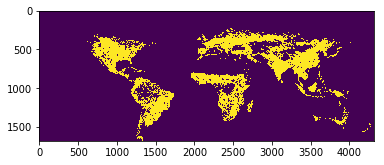

In [6]:
plt.imshow(c);

In [7]:
nc = crops[0][0]
nc = nc.data
nc[nc > 0] = -1
nc[nc == 0] = 1
nc[nc == -1] = 0

In [8]:
nc = mr.cut_array_yboundaries(array=nc, pixelHeight=0.0833333, y_min_old=-90, y_min_new=-56, y_max_old=90, y_max_new=84)

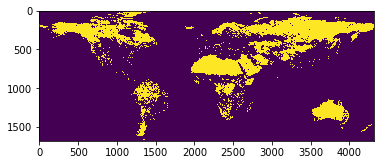

In [9]:
plt.imshow(nc);

In [10]:
impact = mr.MyRaster(os.path.join(out_dir, 'impact_potato.tif'))

In [11]:
out_filename = 'crop_area'
mr.array2geotiff(c, os.path.join(out_dir, out_filename),
                 0, 4320, 1680,
                 -180, 84, 0.0833333, -0.0833333)

In [12]:
out_filename = 'non_crop_area'
mr.array2geotiff(nc, os.path.join(out_dir, out_filename),
                 0, 4320, 1680,
                 -180, 84, 0.0833333, -0.0833333)

In [13]:
filename = 'crop_area.tif'
with rasterio.drivers():
    with rasterio.open(os.path.join(out_dir, filename)) as src:
        image = src.read(1) # first band
        results = ({'properties': {'raster_val': v}, 'geometry': s}
                    for i, (s, v) 
                    in enumerate(shapes(image, mask=None, transform=src.affine)))

In [14]:
geoms = list(results)

In [15]:
gdf = gpd.GeoDataFrame.from_features(geoms)

In [16]:
a = gdf[gdf['raster_val'] == 1]

In [17]:
b = []
for i in a.index:
    b.append(gdf.iloc[i]['geometry'])

In [18]:
c = MultiPolygon(b)

In [19]:
out_filename = 'crop_area.shp'

# Create layer
driver = ogr.GetDriverByName('Esri Shapefile')
ds = driver.CreateDataSource(os.path.join(out_dir, out_filename))
layer = ds.CreateLayer('', None, ogr.wkbMultiPolygon)

# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 1)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(c.wkb)
feat.SetGeometry(geom)

layer.CreateFeature(feat)

# Save and close everything
ds = layer = feat = geom = None

In [20]:
filename = 'non_crop_area.tif'
with rasterio.drivers():
    with rasterio.open(os.path.join(out_dir, filename)) as src:
        image = src.read(1) # first band
        results = ({'properties': {'raster_val': v}, 'geometry': s}
                    for i, (s, v) 
                    in enumerate(shapes(image, mask=None, transform=src.affine)))

In [21]:
geoms = list(results)

In [22]:
gdf = gpd.GeoDataFrame.from_features(geoms)

In [23]:
a = gdf[gdf['raster_val'] == 1]

In [24]:
b = []
for i in a.index:
    b.append(gdf.iloc[i]['geometry'])

In [25]:
c = MultiPolygon(b)

In [26]:
out_filename = 'non_crop_area.shp'

# Create layer
driver = ogr.GetDriverByName('Esri Shapefile')
ds = driver.CreateDataSource(os.path.join(out_dir, out_filename))
layer = ds.CreateLayer('', None, ogr.wkbMultiPolygon)

# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 1)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(c.wkb)
feat.SetGeometry(geom)

layer.CreateFeature(feat)

# Save and close everything
ds = layer = feat = geom = None